# Table of Contents
 <p><div class="lev1"><a href="#Overview"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></div><div class="lev1"><a href="#CD8-vs-CD4"><span class="toc-item-num">2&nbsp;&nbsp;</span>CD8 vs CD4</a></div><div class="lev2"><a href="#reference-profiles-(warmup)"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>reference profiles (warmup)</a></div><div class="lev3"><a href="#run-through-cibersort"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>run through cibersort</a></div><div class="lev2"><a href="#raw-lines-(should-be-quite-hard)"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>raw lines (should be quite hard)</a></div><div class="lev3"><a href="#run-through-cibersort"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>run through cibersort</a></div><div class="lev1"><a href="#Superset-classification"><span class="toc-item-num">3&nbsp;&nbsp;</span>Superset classification</a></div><div class="lev2"><a href="#run-through-cibersort"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>run through cibersort</a></div><div class="lev2"><a href="#analyze-as-above"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>analyze as above</a></div><div class="lev3"><a href="#Observations:"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Observations:</a></div>

In [1]:
# %load ~/ipyhead
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

In [2]:
from StringIO import StringIO

# Overview

Let's try using LM22 to deconvolve some mixtures that we can create.

Here is an example of how to call CIBERSORT: 
`java -Xmx3g -Xms3g -jar CIBERSORT.jar -M ExampleMixtures-GEPs.txt -B LM22.txt`

Just have to do this from R console first:
```
library(Rserve)
Rserve(args="--no-save")
```




# CD8 vs CD4

Do exactly the above, but for types that are hard to tell about.

Take the two most similar types.
Mix them together, with and without noise.
First do this with reference profiles, then with raw data.

Expected results:
* Cibersort will probably do great on reference profiles w/o noise or w/ simple noise
* Slightly less well on reference profiles w/ complex noise -- still good performance but worse than Cibersort on reference profiles of very distinct cell types w/ complex noise
* Same pattern for raw, but perhaps an even larger difference with noise.

The two cell types we choose (see writeup pdf):
* B cells naive
* B cells memory


## reference profiles (warmup)

In [12]:
reference = pd.read_csv('LM22.txt', sep='\t').set_index('Gene symbol')
print reference.shape
reference.head()

(547, 22)


,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Gene symbol,,,,,,,,,,,,,,,,,,,,,
ABCB4,555.713449,10.744235,7.225819,4.311280,4.605860,7.406442,8.043976,6.469993,7.833082,9.312295,...,6.202496,7.951360,27.557710,121.432277,114.636747,4.872184,4.727985,34.113659,15.030530,14.906888
ABCB9,15.603544,22.094787,653.392328,24.223723,35.671507,30.048192,38.455423,17.604795,46.073657,19.715722,...,20.309426,56.251887,29.380878,40.390260,123.993305,23.384603,53.466757,23.615746,29.786442,33.679147
ACAP1,215.305951,321.621021,38.616872,1055.613378,1790.097170,922.152747,340.883424,1107.798265,1995.482601,280.075719,...,190.879024,48.972217,30.974254,23.055150,61.386550,26.412923,104.200198,73.607932,696.442802,596.025961
ACHE,15.117949,16.648847,22.123737,13.428288,27.187732,18.444927,13.441268,14.805542,24.652712,33.658448,...,16.375268,13.692963,1373.069620,48.585761,16.715474,193.159977,13.948778,20.501249,40.414927,22.766494
ACP5,605.897384,1935.201479,1120.104684,306.312519,744.656599,557.819820,248.546932,711.949744,958.916018,493.969120,...,512.931382,13644.172300,1062.475909,7633.960182,13825.053630,3989.865169,263.497930,323.381277,860.563374,307.142798


In [151]:
hard_cols = ['T cells CD8', 'T cells CD4 naive']
reference[hard_cols].shape

(547, 2)

In [152]:
weights = [.5, .5] # as confusing as we can make it -- a direct average
mix7=(reference[hard_cols] * weights).sum(axis=1)
mix7.head()

GeneSymbol
ABCB4     283.228842
ABCB9      18.849165
ACAP1     268.463486
ACHE       15.883398
ACP5     1270.549432
dtype: float64

In [153]:
mix8 = mix7 + np.random.normal(0,1,len(mix7))
mix8.head()


GeneSymbol
ABCB4     281.877613
ABCB9      17.341792
ACAP1     269.652332
ACHE       14.706061
ACP5     1270.305885
dtype: float64

In [154]:
weights_noisy3 = np.reshape(weights*len(mix7), reference[hard_cols].shape)
weights_noisy3 += np.abs(np.random.normal(0,0.1, weights_noisy3.shape)) # using absolute value error
weights_noisy3 = weights_noisy3.clip(0,1)
mix9=(weights_noisy3 * reference[hard_cols]).sum(axis=1)
mix9.shape

(547,)

In [155]:
# write out the reference profile mixtures
hard_mixtures_refprof = pd.DataFrame({'7 NoNoise':mix7, '8 SimpleNoise': mix8, '9 ComplexNoise': mix9})
hard_mixtures_refprof.index.name='GeneSymbol'
hard_mixtures_refprof.to_csv('test_mixtures/hard_reference_profile_mixtures.txt', sep='\t')
print hard_mixtures_refprof.shape
hard_mixtures_refprof.head()

(547, 3)


,7 NoNoise,8 SimpleNoise,9 ComplexNoise
GeneSymbol,,,
ABCB4,283.228842,281.877613,367.980015
ABCB9,18.849165,17.341792,22.014922
ACAP1,268.463486,269.652332,299.624897
ACHE,15.883398,14.706061,19.919718
ACP5,1270.549432,1270.305885,1606.157248


### run through cibersort

In [156]:
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/hard_reference_profile_mixtures.txt -B LM22.txt > test_mixtures/out/c3

In [157]:
results3 = pd.read_csv('test_mixtures/out/c3', skiprows=range(6), sep='\t')
results3.head()

,Column,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),...,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Pearson Correlation,RMSE,Unnamed: 26
0,0,0.500715,0.498280,0.000150,0,0.000205,0.000042,0.000045,0,0,...,0.000035,0.000031,0,0,0.000031,0.000000,0.0,0.999906,0.039525,NaN
1,1,0.500361,0.498309,0.000279,0,0.000249,0.000032,0.000120,0,0,...,0.000186,0.000043,0,0,0.000056,0.000028,0.0,0.999906,0.039696,NaN
2,2,0.492859,0.500923,0.000000,0,0.001332,0.000000,0.001114,0,0,...,0.000810,0.000000,0,0,0.000000,0.000000,0.0,0.998445,0.068860,NaN


In [158]:
del results3['Unnamed: 26']
results3_dat = results3[results3.columns[1:-3]]
print results3.shape, results3_dat.shape
results3_dat.head()

(3, 26) (3, 22)


,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.500715,0.498280,0.000150,0,0.000205,0.000042,0.000045,0,0,0.000000,...,0.000073,0.000000,0,0.000071,0.000035,0.000031,0,0,0.000031,0.000000
1,0.500361,0.498309,0.000279,0,0.000249,0.000032,0.000120,0,0,0.000000,...,0.000014,0.000000,0,0.000025,0.000186,0.000043,0,0,0.000056,0.000028
2,0.492859,0.500923,0.000000,0,0.001332,0.000000,0.001114,0,0,0.000013,...,0.000059,0.000251,0,0.000000,0.000810,0.000000,0,0,0.000000,0.000000


In [159]:
hard_ref_weights = pd.DataFrame(np.zeros(results3_dat.shape),columns=results3_dat.columns)
hard_ref_weights.loc[:,hard_cols] = weights
hard_ref_weights

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
print 'correlation between GT and estimate per mixture'
print results3_dat.corrwith(hard_ref_weights, axis=1)

correlation between GT and estimate per mixture
0    0.999997
1    0.999997
2    0.999954
dtype: float64


Noise again does nothing

absolute difference from ground truth, summarized by column:


/home/maxim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,count,mean,std,min,25%,50%,75%,max
B cells naive,3.0,-0.002022,0.004437,-0.007141,-0.003390,0.000361,0.000538,0.000715
B cells memory,3.0,-0.000829,0.001518,-0.001720,-0.001706,-0.001691,-0.000384,0.000923
Mast cells activated,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T cells CD8,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mast cells resting,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Macrophages M1,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NK cells activated,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T cells follicular helper,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T cells regulatory (Tregs),3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T cells gamma delta,3.0,0.000004,0.000007,0.000000,0.000000,0.000000,0.000006,0.000013


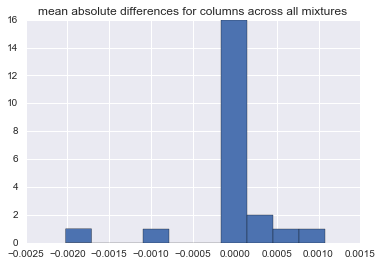

In [162]:
print 'absolute difference from ground truth, summarized by column:'
(results3_dat - hard_ref_weights).describe().loc['mean'].hist()
plt.title('mean absolute differences for columns across all mixtures')
(results3_dat - hard_ref_weights).describe().T.sort('mean')

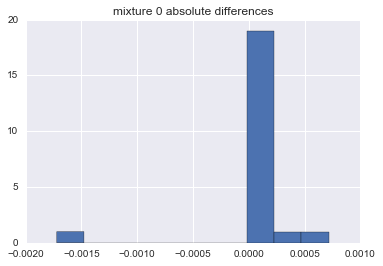

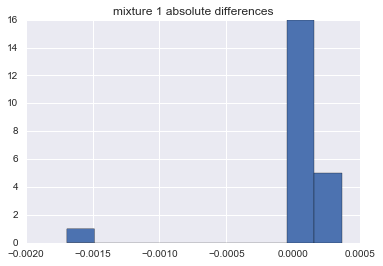

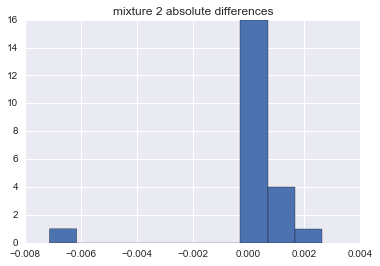

In [163]:
for _, row in (results3_dat - hard_ref_weights).iterrows():
    plt.figure()
    row.hist()
    plt.title('mixture %d absolute differences' % row.name)

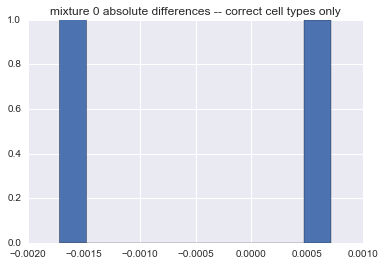

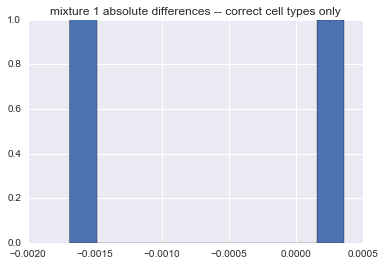

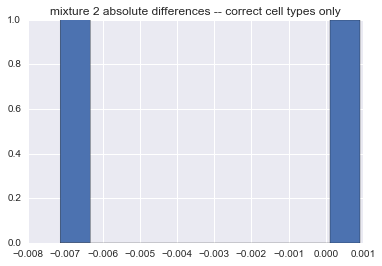

In [164]:
for _, row in (results3_dat - hard_ref_weights).iterrows():
    plt.figure()
    row[hard_cols].hist()
    plt.title('mixture %d absolute differences -- correct cell types only' % row.name)

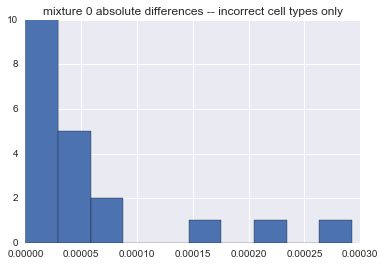

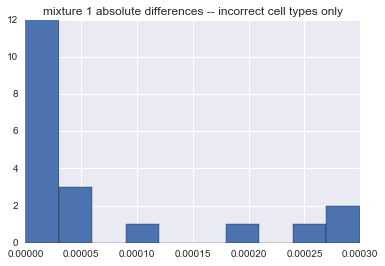

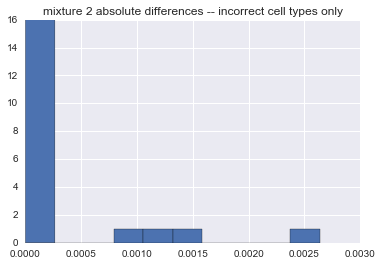

In [165]:
other_cols = set(results3_dat.columns) - set(hard_cols)
for _, row in (results3_dat - hard_ref_weights).iterrows():
    plt.figure()
    row[other_cols].hist()
    plt.title('mixture %d absolute differences -- incorrect cell types only' % row.name)

In [166]:
(results3_dat - hard_ref_weights)[hard_cols]

,B cells naive,B cells memory
0,0.000715,-0.001720
1,0.000361,-0.001691
2,-0.007141,0.000923


Perfect deconvolution, even with noise. Reference profiles are distinct enough.

In [167]:
results3['P-value']

0    0.0
1    0.0
2    0.0
Name: P-value, dtype: float64

Here is RMSE and R^2

In [169]:
print 'RMSE \t R^2 \t per mixture'
from sklearn.metrics import mean_squared_error as mse, r2_score
for (_, y_true),(_, y_pred) in zip(hard_ref_weights.iterrows(), results3_dat.iterrows()):
    print '%0.4f \t %0.4f' % (np.sqrt(mse(y_true, y_pred)), r2_score(y_true, y_pred))

RMSE 	 R^2 	 per mixture
0.0004 	 1.0000
0.0004 	 1.0000
0.0017 	 0.9999


## raw lines (should be quite hard)

In [170]:
for c in cib_raw.columns:
    if 'b cells' in c.lower():
        print c

B cells naive_1
B cells naive_2
B cells naive_3
B cells naive_4
B cells naive_5
B cells naive_6
B cells naive_7
B cells memory_1
B cells memory_2
B cells memory_3
B cells memory_4
B cells memory_5
B cells memory_6
B cells memory_7
B cells memory_8


In [171]:
raw_cols = ['B cells naive_3', 'B cells memory_6']
weights, hard_cols, raw_cols

([0.5, 0.5],
 ['B cells naive', 'B cells memory'],
 ['B cells naive_3', 'B cells memory_6'])

In [172]:
reference[hard_cols].shape

(547, 2)

In [173]:
mix10=(cib_raw[raw_cols] * weights).sum(axis=1)
print mix10.shape
mix10.head()

(11866,)


GeneSymbol
A1CF      650.884112
A2M        27.123923
A4GALT     83.424552
A4GNT     446.775751
AAAS       48.353998
dtype: float64

In [174]:
mix11 = mix10 + np.random.normal(0,1,len(mix10))
print mix11.shape
mix11.head()

(11866,)


GeneSymbol
A1CF      651.032531
A2M        27.661211
A4GALT     83.560924
A4GNT     446.588066
AAAS       48.941654
dtype: float64

In [175]:
weights_noisy4 = np.reshape(weights*len(mix10), cib_raw[raw_cols].shape)
weights_noisy4 += np.abs(np.random.normal(0,0.1, weights_noisy4.shape)) # using absolute value error
weights_noisy4 = weights_noisy4.clip(0,1)
mix12=(weights_noisy4 * cib_raw[raw_cols]).sum(axis=1)
print mix12.shape
mix12.head()

(11866,)


GeneSymbol
A1CF      857.619128
A2M        28.258246
A4GALT     86.328255
A4GNT     546.221032
AAAS       53.313285
dtype: float64

In [176]:
# write out the reference profile mixtures
hard_mixtures_rawline = pd.DataFrame({'10 NoNoise':mix10, '11 SimpleNoise': mix11, '12 ComplexNoise': mix12})
hard_mixtures_rawline.index.name='GeneSymbol'
hard_mixtures_rawline.to_csv('test_mixtures/hard_rawline_mixtures.txt', sep='\t')
print hard_mixtures_rawline.shape
hard_mixtures_rawline.head()

(11866, 3)


,10 NoNoise,11 SimpleNoise,12 ComplexNoise
GeneSymbol,,,
A1CF,650.884112,651.032531,857.619128
A2M,27.123923,27.661211,28.258246
A4GALT,83.424552,83.560924,86.328255
A4GNT,446.775751,446.588066,546.221032
AAAS,48.353998,48.941654,53.313285


### run through cibersort

In [177]:
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/hard_rawline_mixtures.txt -B LM22.txt > test_mixtures/out/c4

In [178]:
results4 = pd.read_csv('test_mixtures/out/c4', skiprows=range(6), sep='\t')
results4.head()

,Column,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),...,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Pearson Correlation,RMSE,Unnamed: 26
0,0,0.393882,0.535980,0,0,0,0.012840,0,0.006687,0.001908,...,0.012705,0,0.000000,0.009541,0.004982,0.000430,0.0,0.952778,0.308847,NaN
1,1,0.395699,0.536218,0,0,0,0.013131,0,0.006515,0.002048,...,0.012098,0,0.000000,0.009604,0.004693,0.000430,0.0,0.952767,0.308529,NaN
2,2,0.409547,0.505164,0,0,0,0.024600,0,0.011651,0.001387,...,0.014114,0,0.006186,0.001995,0.007005,0.004249,0.0,0.948466,0.322878,NaN


In [179]:
del results4['Unnamed: 26']
results4_dat = results4[results4.columns[1:-3]]
print results4.shape, results4_dat.shape
results4_dat.head()

(3, 26) (3, 22)


,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.393882,0.535980,0,0,0,0.012840,0,0.006687,0.001908,0.004782,...,0.004679,0.00000,0.005447,0,0.012705,0,0.000000,0.009541,0.004982,0.000430
1,0.395699,0.536218,0,0,0,0.013131,0,0.006515,0.002048,0.004932,...,0.002916,0.00000,0.005651,0,0.012098,0,0.000000,0.009604,0.004693,0.000430
2,0.409547,0.505164,0,0,0,0.024600,0,0.011651,0.001387,0.000672,...,0.000000,0.00081,0.004431,0,0.014114,0,0.006186,0.001995,0.007005,0.004249


In [180]:
hard_ref_weights

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
print 'correlation between GT and estimate per mixture'
print results4_dat.corrwith(hard_ref_weights, axis=1)

correlation between GT and estimate per mixture
0    0.986767
1    0.987114
2    0.992914
dtype: float64


absolute difference from ground truth, summarized by column:


/home/maxim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,count,mean,std,min,25%,50%,75%,max
B cells naive,3.0,-0.100291,0.008568,-0.106118,-0.105209,-0.104301,-0.097377,-0.090453
Dendritic cells activated,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Plasma cells,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T cells CD8,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T cells CD4 naive,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Macrophages M2,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T cells CD4 memory activated,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Macrophages M0,3.0,0.000270,0.000468,0.000000,0.000000,0.000000,0.000405,0.000810
Neutrophils,3.0,0.001703,0.002205,0.000430,0.000430,0.000430,0.002340,0.004249
T cells regulatory (Tregs),3.0,0.001781,0.000348,0.001387,0.001647,0.001908,0.001978,0.002048


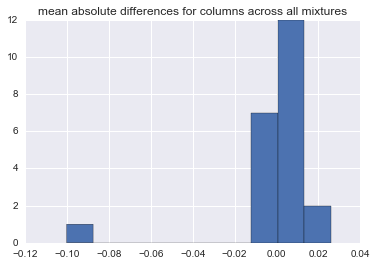

In [183]:
print 'absolute difference from ground truth, summarized by column:'
(results4_dat - hard_ref_weights).describe().loc['mean'].hist()
plt.title('mean absolute differences for columns across all mixtures')
(results4_dat - hard_ref_weights).describe().T.sort('mean')

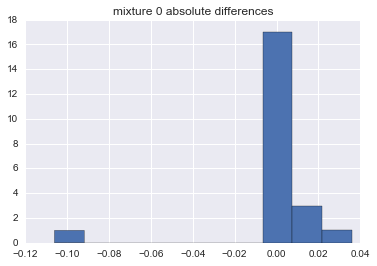

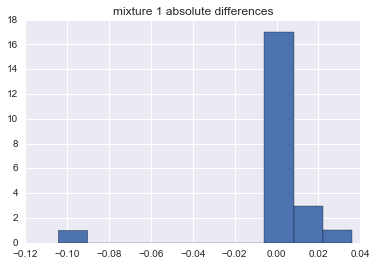

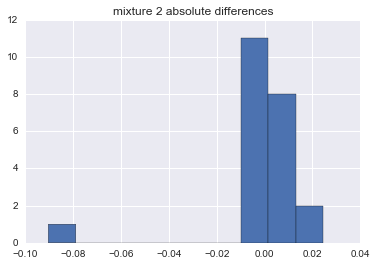

In [184]:
for _, row in (results4_dat - hard_ref_weights).iterrows():
    plt.figure()
    row.hist()
    plt.title('mixture %d absolute differences' % row.name)

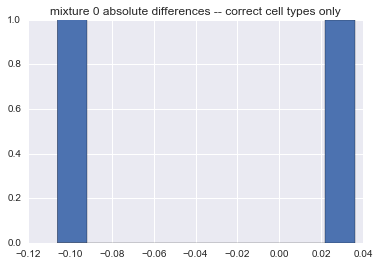

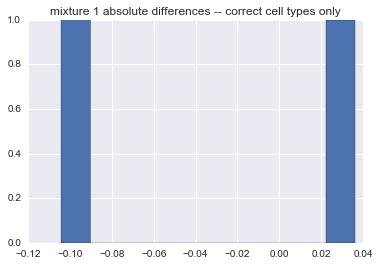

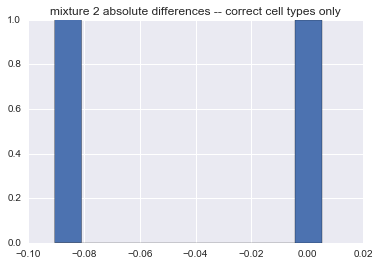

In [185]:
for _, row in (results4_dat - hard_ref_weights).iterrows():
    plt.figure()
    row[hard_cols].hist()
    plt.title('mixture %d absolute differences -- correct cell types only' % row.name)

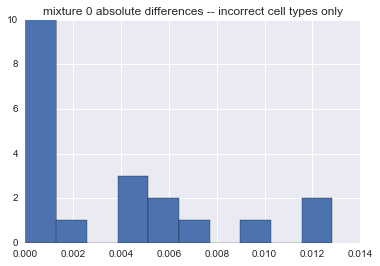

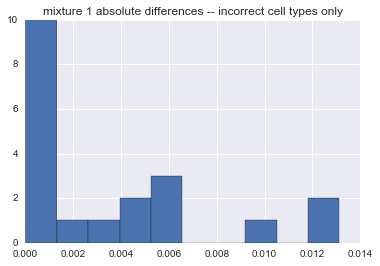

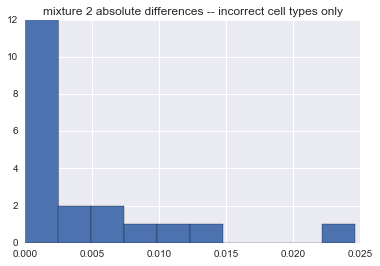

In [186]:
other_cols = set(results4_dat.columns) - set(hard_cols)
for _, row in (results4_dat - hard_ref_weights).iterrows():
    plt.figure()
    row[other_cols].hist()
    plt.title('mixture %d absolute differences -- incorrect cell types only' % row.name)

In [187]:
(results4_dat - hard_ref_weights)[hard_cols]

,B cells naive,B cells memory
0,-0.106118,0.035980
1,-0.104301,0.036218
2,-0.090453,0.005164


In [188]:
results4['P-value']

0    0.0
1    0.0
2    0.0
Name: P-value, dtype: float64

In [189]:
print 'RMSE \t R^2 \t per mixture'
from sklearn.metrics import mean_squared_error as mse, r2_score
for (_, y_true),(_, y_pred) in zip(hard_ref_weights.iterrows(), results4_dat.iterrows()):
    print '%0.4f \t %0.4f' % (np.sqrt(mse(y_true, y_pred)), r2_score(y_true, y_pred))

RMSE 	 R^2 	 per mixture
0.0245 	 0.9711
0.0241 	 0.9719
0.0206 	 0.9794


Consistently 10% off with at least one category. Diagnostics don't reveal that -- especially P value. Cibersort thinks it did a great job, but it did not.

Also, have hallucination of CD4 memory resting T cells (1.7%), resting dendritic cells (1.3%). (All others are at < 1%)



# Superset classification

The classification:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Hematopoiesis_simple.svg/2000px-Hematopoiesis_simple.svg.png" width="75%" />

How LM22 reproduces it (partially):

![Hierarchical clustering of Cibersort's LM22](lm22.png)




A good test case may be:

* B cells: "plasma cells" and "B cells*"
* Myeloblasts: "Monocytes" + "Macrophages.M0" + "Eosinophils" + "Neutrophils"
* T cells: "T cells*"

These types are biologically relevant and also seem to be reproduced in the hierarchical clustering above, for the most part.

We want a superset profile of what is in common between cell types -- not an average.
So pass in all T cells together to the Cibersort basis construction mechanism, for example.

In [190]:
# from Variance\ within\ and\ between\ cell\ types.ipynb
lm22_orig_classes = pd.read_csv('curated_data/pure_samples/cibersort/LM22-classes.txt', sep='\t', header=None)
lm22_orig_classes = lm22_orig_classes.set_index(0)
lm22_orig_classes.head()

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
0,,,,,,,,,,,,,,,,,,,,,
B cells naive,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
B cells memory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
Plasma cells,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
T cells CD8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
T cells CD4 naive,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,2,0,2


In [38]:
sample_names = pd.read_csv('curated_data/pure_samples/cibersort/LM22-ref-sample.txt', sep='\t').columns
sample_names

Index([u'Relabel',
       u'A_LW_+BAFF_U133A_250303 [Chtanova_immune|A_LW_+BAFF_U133A_250303]',
       u'A_LW_+BAFF_U133A_70303 [Chtanova_immune|A_LW_+BAFF_U133A_70303]',
       u'A_LW_-BAFF_U133A_250303 [Chtanova_immune|A_LW_-BAFF_U133A_250303]',
       u'A_LW_-BAFF_U133A_70303 [Chtanova_immune|A_LW_-BAFF_U133A_70303]',
       u'A_LW_CD57+_U133A_030603 [Chtanova_immune|A_LW_CD57+_U133A_030603]',
       u'A_LW_CD57+_U133A_121102 [Chtanova_immune|A_LW_CD57+_U133A_121102]',
       u'A_LW_CD57-_U133A_030603 [Chtanova_immune|A_LW_CD57-_U133A_030603]',
       u'A_LW_CD57-_U133A_121102 [Chtanova_immune|A_LW_CD57-_U133A_121102]',
       u'A_LW_DC+BAFF_U133A_250304 [Chtanova_immune|A_LW_DC+BAFF_U133A_250304]',
       ...
       u'TEM_U133A_1 [TFH_E-MEXP-750|TEM_U133A_1]',
       u'TEM_U133A_2 [TFH_E-MEXP-750|TEM_U133A_2]',
       u'TEM_U133A_3 [TFH_E-MEXP-750|TEM_U133A_3]',
       u'TN_U133A_1 [TFH_E-MEXP-750|TN_U133A_1]',
       u'TN_U133A_2 [TFH_E-MEXP-750|TN_U133A_2]',
       u'TN_U133A_3 [

In [30]:
bcells = lm22_orig_classes.loc[['B cells naive', 'B cells memory', 'Plasma cells'], :]
bcells.head()

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
0,,,,,,,,,,,,,,,,,,,,,
B cells naive,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
B cells memory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
Plasma cells,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2


In [40]:
def combine_rows(col):
    if (1 in col.unique() and 2 in col.unique()):
        print sample_names[col.name], col.name
    if 1 in col.unique():
        return 1
    if 2 in col.unique():
        return 2
    return 0
bcells.apply(combine_rows).unique()

Bcell-naive-1 [HG-U133A] [IRIS_GSE22886|GSM565308] 89
Bcell-naive-2 [HG-U133A] [IRIS_GSE22886|GSM565309] 90
Bcell-naive-3 [HG-U133A] [IRIS_GSE22886|GSM565310] 91
Bcell-naive-4 [HG-U133A] [IRIS_GSE22886|GSM565311] 92
Bcell-naive-5 [HG-U133A] [IRIS_GSE22886|GSM565312] 93
Bcell-naive-6 [HG-U133A] [IRIS_GSE22886|GSM565313] 94
Bcell-naive-7 [HG-U133A] [IRIS_GSE22886|GSM565314] 95
Bcell-Memory_IgG_IgA-1 [HG-U133A] [IRIS_GSE22886|GSM565315] 96
Bcell-Memory_IgG_IgA-2 [HG-U133A] [IRIS_GSE22886|GSM565316] 97
Bcell-Memory_IgG_IgA-3 [HG-U133A] [IRIS_GSE22886|GSM565317] 98
Bcell-Memory_IgG_IgA-4 [HG-U133A] [IRIS_GSE22886|GSM565318] 99
Bcell-Memory_IgM-1 [HG-U133A] [IRIS_GSE22886|GSM565319] 100
Bcell-Memory_IgM-2 [HG-U133A] [IRIS_GSE22886|GSM565320] 101
Bcell-Memory_IgM-3 [HG-U133A] [IRIS_GSE22886|GSM565321] 102
Bcell-Memory_IgM-4 [HG-U133A] [IRIS_GSE22886|GSM565322] 103
PlasmaCell-FromPBMC-1 [HG-U133A] [IRIS_GSE22886|GSM565323] 104
PlasmaCell-FromPBMC-2 [HG-U133A] [IRIS_GSE22886|GSM565324] 105
Plas

array([0, 2, 1])

In [41]:
bcells[range(89,110)]

,89,90,91,92,93,94,95,96,97,98,...,100,101,102,103,104,105,106,107,108,109
0,,,,,,,,,,,,,,,,,,,,,
B cells naive,1,1,1,1,1,1,1,2,2,2,...,2,2,2,2,2,2,2,2,2,2
B cells memory,2,2,2,2,2,2,2,1,1,1,...,1,1,1,1,2,2,2,2,2,2
Plasma cells,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,1,1,1,1,1,1


In [49]:
def test_f(col):
    if all(col == 0):
        print sample_names[col.name]
print 'columns that are all 0'
_ = lm22_orig_classes.apply(test_f)

print

def test_f2(col):
    if len(col.unique()) == 3:
        print sample_names[col.name]
print 'columns that have some 0s, 1s, and 2s'
_ = lm22_orig_classes.apply(test_f2)

print

def test_f3(col):
    if len(col.unique()) == 2 and not any(col==2):
        print sample_names[col.name]
print 'columns that are all 0s and 1s'
_ = lm22_orig_classes.apply(test_f3)

print

def test_f4(col):
    if len(col.unique()) == 2 and not any(col==0):
        print sample_names[col.name]
print 'columns that are all 1s and 2s'
_ = lm22_orig_classes.apply(test_f4)


columns that are all 0
A_LW_+BAFF_U133A_250303 [Chtanova_immune|A_LW_+BAFF_U133A_250303]
A_LW_+BAFF_U133A_70303 [Chtanova_immune|A_LW_+BAFF_U133A_70303]
A_LW_-BAFF_U133A_250303 [Chtanova_immune|A_LW_-BAFF_U133A_250303]
A_LW_-BAFF_U133A_70303 [Chtanova_immune|A_LW_-BAFF_U133A_70303]
A_LW_CD57+_U133A_030603 [Chtanova_immune|A_LW_CD57+_U133A_030603]
A_LW_CD57+_U133A_121102 [Chtanova_immune|A_LW_CD57+_U133A_121102]
A_LW_CD57-_U133A_030603 [Chtanova_immune|A_LW_CD57-_U133A_030603]
A_LW_CD57-_U133A_121102 [Chtanova_immune|A_LW_CD57-_U133A_121102]
A_LW_DC+BAFF_U133A_250304 [Chtanova_immune|A_LW_DC+BAFF_U133A_250304]
A_LW_DC-BAFF_U133A_250304 [Chtanova_immune|A_LW_DC-BAFF_U133A_250304]
A_LW_DC48hLPS_HC_U133A [Chtanova_immune|A_LW_DC48hLPS_HC_U133A]
A_LW_DC48hLPS_U133A_200503 [Chtanova_immune|A_LW_DC48hLPS_U133A_200503]
A_LW_DC6hLPS_HC_U133A [Chtanova_immune|A_LW_DC6hLPS_HC_U133A]
A_LW_DC6hLPS_U133A_200503 [Chtanova_immune|A_LW_DC6hLPS_U133A_200503]
A_LW_imDC_U133A_200503 [Chtanova_immune|A_LW_


What do 0,1,2 mean? No columns have all three and no columns have only 0s and 1s. All columns either have all 1s and 2s or all 0s. Columns with all 0s are never compared against.

So to form our own classes we want to keep columns that are all 0s as all 0s, put 1s for columns we care about, and 2s for everything else.

In [51]:
def combine_rows(col):
    # if we have at least 1 zero in this filtered list, then it's a column of all 0s 
    # keep it that way
    if 0 in col.unique():
        return 0
    if 1 in col.unique():
        return 1
    return 2
bcells.apply(combine_rows).unique()

array([0, 2, 1])

In [57]:
for c in lm22_orig_classes.index:
    if 'T cell' in c:
        print c

T cells CD8
T cells CD4 naive
T cells CD4 memory resting
T cells CD4 memory activated
T cells follicular helper
T cells gamma delta
T cells regulatory (Tregs)


In [58]:
tcells = lm22_orig_classes.loc[[
        'T cells CD8',
        'T cells CD4 naive',
        'T cells CD4 memory resting',
        'T cells CD4 memory activated',
        'T cells follicular helper',
        #'T cells gamma delta', # exclude because these are weird
        'T cells regulatory (Tregs)'
                               ], :]
tcells.head()

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
0,,,,,,,,,,,,,,,,,,,,,
T cells CD8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
T cells CD4 naive,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,2,0,2
T cells CD4 memory resting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
T cells CD4 memory activated,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
T cells follicular helper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2


In [60]:
print lm22_orig_classes.index

Index([u'B cells naive', u'B cells memory', u'Plasma cells', u'T cells CD8',
       u'T cells CD4 naive', u'T cells CD4 memory resting',
       u'T cells CD4 memory activated', u'T cells follicular helper',
       u'T cells gamma delta', u'T cells regulatory (Tregs)',
       u'NK cells resting', u'NK cells activated', u'Monocytes',
       u'Macrophages M0', u'Macrophages M1', u'Macrophages M2',
       u'Dendritic cells resting', u'Dendritic cells activated',
       u'Mast cells resting', u'Mast cells activated', u'Eosinophils',
       u'Neutrophils'],
      dtype='object', name=0)


In [61]:
myeloblasts = lm22_orig_classes.loc[['Monocytes',
                                     'Macrophages M0',
                                     'Eosinophils',
                                     'Neutrophils'
                                    ], :]
myeloblasts.head()

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
0,,,,,,,,,,,,,,,,,,,,,
Monocytes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
Macrophages M0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
Eosinophils,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
Neutrophils,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2


In [64]:
new_classes = pd.DataFrame({'B cells': bcells.apply(combine_rows),
             'T cells': tcells.apply(combine_rows),
             'Myeloblasts': myeloblasts.apply(combine_rows)}).T
new_classes

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
B cells,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
Myeloblasts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,0,2,0,2
T cells,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,0,1


In [65]:
new_classes.to_csv('test_mixtures/newclasses.txt', sep='\t', header=None)


## run through cibersort

we keep the option to do post-processing of genes enabled

first, make the signature matrix (specify any mixture). then, run through the following mixtures:

* B cell naive, Treg
	* test_mixtures/reference_profile_mixtures.txt
	* test_mixtures/raw_line_mixtures.txt
* B cell naive, B cell memory
	* test_mixtures/hard_reference_profile_mixtures.txt
	* test_mixtures/hard_rawline_mixtures.txt

In [191]:
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/reference_profile_mixtures.txt -P curated_data/pure_samples/cibersort/LM22-ref-sample.txt -c test_mixtures/newclasses.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True

>===================Settings====================
>Mixture file: test_mixtures/reference_profile_mixtures.txt
>Pure samples file: curated_data/pure_samples/cibersort/LM22-ref-sample.txt
>Phenotype classes file: test_mixtures/newclasses.txt
>Number of permutations set to: 100
>Enable verbose output
>Q-value for signature matrix construction set to: 0.3
>Maximum kappa set to: 999.0
>Minimum number of DEGs to consider from each phenotype for signature matrix set to: 50
>Maximum number of DEGs to consider from each phenotype for signature matrix set to: 150
>Enable signature matrix filtration (non-hematopoietic genes will be removed)
>===============================================
>R version 3.2.3 (2015-12-10)
>Loaded 194 columns and 11845 rows
^C


In [7]:
!mv "curated_data/pure_samples/cibersort/newclasses.LM22-ref-sample.bm.K999.0.txt" test_mixtures/

In [8]:
!mv "curated_data/pure_samples/cibersort/newclasses.LM22-ref-sample.bm.heatmap.K999.0.pdf" test_mixtures/

In [10]:
!mkdir -p test_mixtures/out

In [192]:
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/reference_profile_mixtures.txt -B test_mixtures/newclasses.LM22-ref-sample.bm.K999.0.txt > test_mixtures/out/NC1

In [193]:
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/raw_line_mixtures.txt -B test_mixtures/newclasses.LM22-ref-sample.bm.K999.0.txt > test_mixtures/out/NC2

In [194]:
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/hard_reference_profile_mixtures.txt -B test_mixtures/newclasses.LM22-ref-sample.bm.K999.0.txt > test_mixtures/out/NC3

In [195]:
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/hard_rawline_mixtures.txt -B test_mixtures/newclasses.LM22-ref-sample.bm.K999.0.txt > test_mixtures/out/NC4

In [196]:
!cat test_mixtures/out/NC4

>===================Settings====================
>Mixture file: test_mixtures/hard_rawline_mixtures.txt
>Signature matrix file: test_mixtures/newclasses.LM22-ref-sample.bm.K999.0.txt
>===============================================
>R version 3.2.3 (2015-12-10)
>==================CIBERSORT====================
Column	B cells	Myeloblasts	T cells	P-value	Pearson Correlation	RMSE	
0	0.9654110306870105	0.020131155134812014	0.014457814178177491	0.0	0.9624429898696041	0.3925547691360565
1	0.9656096410966829	0.020135681992628388	0.014254676910688675	0.0	0.9624487592440291	0.3927097171474575
2	0.9744789639479781	0.02552103605202189	0	0.0	0.9617012824677748	0.40233635268131984


In [197]:
results = []
results_dats=[]
for i in range(1,5):
    dftmp = pd.read_csv('test_mixtures/out/NC%d' % i, skiprows=range(6), sep='\t')
    del dftmp['Unnamed: 7']
    results.append(dftmp)
    results_dats.append(dftmp[dftmp.columns[1:-3]])

In [198]:
assert len(results) == len(results_dats) == 4


## analyze as above

NC1,NC2 have weights .2,.6 for B cell naive, Treg. NC3, NC4 have weights .5, .5 for B cell naive, memory.

In [199]:
ref_1 = pd.DataFrame(np.zeros(results_dats[0].shape), columns=results_dats[0].columns)
ref_1.loc[:, ['B cells', 'T cells']] = [.25, .75]
ref_1.head()

,B cells,Myeloblasts,T cells
0,0.25,0.0,0.75
1,0.25,0.0,0.75
2,0.25,0.0,0.75


In [200]:
ref_2 = pd.DataFrame(np.zeros(results_dats[2].shape), columns=results_dats[2].columns)
ref_2.loc[:, ['B cells']] = 1.0
ref_2.head()

,B cells,Myeloblasts,T cells
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0


In [201]:
experiment_names = [
    'B vs T: reference profiles',
    'B vs T: raw lines',
    'B vs B: reference profiles',
    'B vs B: raw lines'
]

In [202]:
reference_dats = [ref_1, ref_1, ref_2, ref_2]

In [203]:
for experiment_name, result, resultdat, groundtruth in zip(\
        experiment_names, results, results_dats, reference_dats):
    print experiment_name
    
    #print 'absolute difference from ground truth, summarized by column:'
    #print (resultdat - groundtruth).describe()

#     correct_cols = groundtruth.apply(lambda col: not all(col==0))
#     correct_cols = correct_cols[correct_cols==True].index.tolist()
    
#     fig, axarr = plt.subplots(3, 3, figsize=(20,20))

#     for (_, row), ax in zip((resultdat - groundtruth).iterrows(), axarr[0,:]):
#         row.hist(ax=ax)
#         ax.set_title('mixture %d absolute differences' % row.name)


#     for (_, row), ax in zip((resultdat - groundtruth).iterrows(), axarr[1,:]):
#         row[correct_cols].hist(ax=ax)
#         ax.set_title('mixture %d absolute differences -- correct cell types only' % row.name)



#     other_cols = set(resultdat.columns) - set(correct_cols)
#     for (_, row), ax in zip((resultdat - groundtruth).iterrows(), axarr[2,:]):
#         row[other_cols].hist(ax=ax)
#         ax.set_title('mixture %d absolute differences -- incorrect cell types only' % row.name)
    
#     fig.suptitle(experiment_name)

    print 'p values:', result['P-value']

    print 'RMSE \t R^2 \t per mixture'
    from sklearn.metrics import mean_squared_error as mse, r2_score
    for (_, y_true),(_, y_pred) in zip(groundtruth.iterrows(), resultdat.iterrows()):
        print '%0.4f \t %0.4f' % (np.sqrt(mse(y_true, y_pred)), r2_score(y_true, y_pred))

    print 'absolute difference from ground truth'
    print (resultdat - groundtruth)
    
    print

B vs T: reference profiles
p values: 0    0.0
1    0.0
2    0.0
Name: P-value, dtype: float64
RMSE 	 R^2 	 per mixture
0.0071 	 0.9995
0.0071 	 0.9995
0.0237 	 0.9942
absolute difference from ground truth
    B cells  Myeloblasts   T cells
0 -0.008683          0.0  0.008683
1 -0.008703          0.0  0.008703
2  0.029078          0.0 -0.029078

B vs T: raw lines
p values: 0    0.0
1    0.0
2    0.0
Name: P-value, dtype: float64
RMSE 	 R^2 	 per mixture
0.0380 	 0.9851
0.0379 	 0.9853
0.0164 	 0.9972
absolute difference from ground truth
    B cells  Myeloblasts   T cells
0 -0.046572          0.0  0.046572
1 -0.046369          0.0  0.046369
2 -0.020146          0.0  0.020146

B vs B: reference profiles
p values: 0    0.0
1    0.0
2    0.0
Name: P-value, dtype: float64
RMSE 	 R^2 	 per mixture
0.0044 	 0.9999
0.0043 	 0.9999
0.0078 	 0.9997
absolute difference from ground truth
    B cells  Myeloblasts   T cells
0 -0.005344          0.0  0.005344
1 -0.005314          0.0  0.005314
2 -0.00

In [204]:
dfs = []
for experiment_name, result, resultdat, groundtruth in zip(\
        experiment_names, results, results_dats, reference_dats):
    print experiment_name
    
    tmp=(resultdat - groundtruth)
    tmp['noise_level'] = tmp.index
    tmp = pd.melt(tmp, id_vars=['noise_level'], var_name='cell_type', value_name='error')
    tmp['experiment'] = experiment_name
    dfs.append(tmp)

dfs = pd.concat(dfs)
dfs

B vs T: reference profiles
B vs T: raw lines
B vs B: reference profiles
B vs B: raw lines


,noise_level,cell_type,error,experiment
0,0,B cells,-0.008683,B vs T: reference profiles
1,1,B cells,-0.008703,B vs T: reference profiles
2,2,B cells,0.029078,B vs T: reference profiles
3,0,Myeloblasts,0.000000,B vs T: reference profiles
4,1,Myeloblasts,0.000000,B vs T: reference profiles
5,2,Myeloblasts,0.000000,B vs T: reference profiles
6,0,T cells,0.008683,B vs T: reference profiles
7,1,T cells,0.008703,B vs T: reference profiles
8,2,T cells,-0.029078,B vs T: reference profiles
0,0,B cells,-0.046572,B vs T: raw lines


Error plot


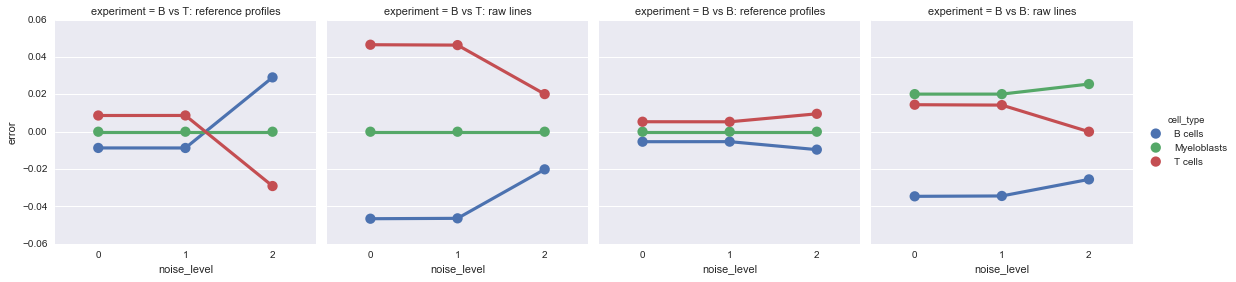

In [206]:
print 'Error plot'
g = sns.factorplot(data=dfs, x="noise_level", y="error", hue="cell_type", col="experiment")
g.savefig('plots/superclass_error.png', dpi=300)

(Note that "reference profiles" means of subtypes)


### Observations:

We are doing a very simple B vs T and B vs B superclass classification. Threw in myeloblasts in training data as well to measure hallucination of related types.

In general we do superclass classification fairly well -- see the scale (max error is 5-6%).
This motivates the hierarchy approach. (The remaining question there is whether we have enough confidence to jump one level down -- a Bayesian approach can answer that)

In some cases the noise helps, in others it hurts. Still doesn't affect that much -- just 5%.

Rightmost plot: some hallucination of myeloblasts.

* B vs T when using reference profile: very little error, a little more with noise.
* B vs T raw lines: the proportion of T cells is overestimated while B cells underestimated. Why is that? Is that because of the relative weights $(.25,.75)$?
* B vs B when using reference profile: very little error, as expected.
* B vs B when using a raw line: have some hallucination of myeloblasts especially, but also of T cells. The proportion of B cells is slightly underestimated unfortunately, but still very close to 100%.
* Why is noise almost always good at reducing error?

Looks like we are doing superclass classification well!

In [ ]:
|